In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [21]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,15,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    #total_coords = np.hstack((airfoil_coord, flap_coords))
    total_coords = flap_coords
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,15))
    flap_right = np.zeros((15,15))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/15, -h[i], 15).reshape((-1,1))
        yRight = np.linspace(-h[i]/15, -h[i], 15).reshape((-1,1))
        xLeft = 0.5*np.ones((15,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((15,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,15))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [22]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 15)
Dimension - total coordinates:  (6000, 15)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 15, 1)
Dimension - y:  (3000, 1)


In [23]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [24]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [25]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [33]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,15,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [34]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2, 15, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 15, 400)   2000        ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 1, 7, 400)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten_1 (Flatten)            (None, 2800)         0           ['max_pooling2d_1[0][0]']        
                                                                                            

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [36]:
model_directory = "D:\\TrainedModels\\20230103\\3Case(131415)(l2)(flapOnly15Coords)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [37]:
ckpt_name = model_directory + "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [38]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [39]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.1803 - rmse: 0.4245
Epoch 1: val_loss improved from inf to 0.16075, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 16s 75ms/step - loss: 0.1807 - rmse: 0.4249 - val_loss: 0.1608 - val_rmse: 0.4008 - lr: 1.0000e-04
Epoch 2/10000
10/10 [==============================] - ETA: 0s - loss: 0.1540 - rmse: 0.3923
Epoch 2: val_loss improved from 0.16075 to 0.12762, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 28ms/step - loss: 0.1540 - rmse: 0.3923 - val_loss: 0.1276 - val_rmse: 0.3570 - lr: 1.0000e-04
Epoch 3/10000
 6/10 [================

Epoch 18/10000
10/10 [==============================] - ETA: 0s - loss: 0.0421 - rmse: 0.2048
Epoch 18: val_loss improved from 0.04439 to 0.04085, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 27ms/step - loss: 0.0421 - rmse: 0.2048 - val_loss: 0.0409 - val_rmse: 0.2018 - lr: 1.0000e-04
Epoch 19/10000
10/10 [==============================] - ETA: 0s - loss: 0.0390 - rmse: 0.1972
Epoch 19: val_loss improved from 0.04085 to 0.03663, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 32ms/step - loss: 0.0390 - rmse: 0.1972 - val_loss: 0.0366 - val_rmse: 0.1910 - lr: 1.0000e-04
Epoch 20/10000
 6/10 [========

Epoch 35/10000
10/10 [==============================] - ETA: 0s - loss: 0.0041 - rmse: 0.0628
Epoch 35: val_loss improved from 0.00441 to 0.00397, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 28ms/step - loss: 0.0041 - rmse: 0.0628 - val_loss: 0.0040 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 36/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0038 - rmse: 0.0601
Epoch 36: val_loss improved from 0.00397 to 0.00370, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 28ms/step - loss: 0.0038 - rmse: 0.0607 - val_loss: 0.0037 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 37/10000
10/10 [========

Epoch 53/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0017 - rmse: 0.0396
Epoch 53: val_loss did not improve from 0.00171
10/10 [==============================] - 0s 17ms/step - loss: 0.0017 - rmse: 0.0394 - val_loss: 0.0018 - val_rmse: 0.0404 - lr: 1.0000e-04
Epoch 54/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 54: val_loss improved from 0.00171 to 0.00167, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 27ms/step - loss: 0.0017 - rmse: 0.0394 - val_loss: 0.0017 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 55/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0016 - rmse: 0.0385
Epoch 55: val_loss improved from 0.00167 to 0.00158, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103un

10/10 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0333 - val_loss: 0.0012 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 77/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0343    
Epoch 77: val_loss did not improve from 0.00117
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0343 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 78/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0322
Epoch 78: val_loss improved from 0.00117 to 0.00116, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0012 - rmse: 0.0325 - val_loss: 0.0012 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 79/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.03

Epoch 101/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0325
Epoch 101: val_loss improved from 0.00104 to 0.00104, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0012 - rmse: 0.0323 - val_loss: 0.0010 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 102/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0324
Epoch 102: val_loss did not improve from 0.00104
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0324 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 103/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 103: val_loss did not improve from 0.00104
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0331 - 

10/10 [==============================] - 0s 11ms/step - loss: 9.9201e-04 - rmse: 0.0293 - val_loss: 9.9663e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 124/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0300
Epoch 124: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0302 - val_loss: 9.7600e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 125/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0295    
Epoch 125: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0295 - val_loss: 9.6772e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 126/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0305
Epoch 126: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0305 - val_loss: 9.5266e-04 - val_rmse: 0.0286 - lr:

10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 9.1257e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 151/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.9852e-04 - rmse: 0.0295
Epoch 151: val_loss did not improve from 0.00091
10/10 [==============================] - 0s 11ms/step - loss: 9.9740e-04 - rmse: 0.0295 - val_loss: 9.4388e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 152/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.3410e-04 - rmse: 0.0284
Epoch 152: val_loss did not improve from 0.00091
10/10 [==============================] - 0s 11ms/step - loss: 9.3928e-04 - rmse: 0.0285 - val_loss: 9.3852e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 153/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 153: val_loss did not improve from 0.00091
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0302 - val_loss: 9.5351e-04 - val_rmse: 0.02

 8/10 [=======================>......] - ETA: 0s - loss: 9.9165e-04 - rmse: 0.0295
Epoch 178: val_loss did not improve from 0.00091
10/10 [==============================] - 0s 11ms/step - loss: 9.7003e-04 - rmse: 0.0291 - val_loss: 9.7276e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 179/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.8634e-04 - rmse: 0.0294
Epoch 179: val_loss did not improve from 0.00091
10/10 [==============================] - 0s 11ms/step - loss: 9.9109e-04 - rmse: 0.0295 - val_loss: 9.6942e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 180/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0303    
Epoch 180: val_loss did not improve from 0.00091
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 9.6481e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 181/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.3571e-04 - rmse: 0.0285
Epoch 181: val_loss did not improve 

10/10 [==============================] - 0s 18ms/step - loss: 9.3330e-04 - rmse: 0.0285 - val_loss: 8.8669e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 204/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0305    
Epoch 204: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 205/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 205: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 9.2619e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 206/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0322
Epoch 206: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e

Epoch 232/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 232: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0323 - val_loss: 0.0011 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 233/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 233: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 234/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0304    
Epoch 234: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0307 - val_loss: 9.5887e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 235/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0303    
Epoch 235: val_loss did not improve from 0.0

Epoch 259/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.8533e-04 - rmse: 0.0296
Epoch 259: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 9.7881e-04 - rmse: 0.0295 - val_loss: 9.2160e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 260/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9480e-04 - rmse: 0.0280
Epoch 260: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 8.8635e-04 - rmse: 0.0279 - val_loss: 8.8840e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 261/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5827e-04 - rmse: 0.0291
Epoch 261: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 10ms/step - loss: 9.2644e-04 - rmse: 0.0286 - val_loss: 9.2374e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 262/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.8929e-04 - rmse: 0.0297
Epoch 262: val_l

10/10 [==============================] - 0s 11ms/step - loss: 9.4684e-04 - rmse: 0.0290 - val_loss: 9.3847e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 287/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.6430e-04 - rmse: 0.0293
Epoch 287: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 9.4404e-04 - rmse: 0.0289 - val_loss: 9.4319e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 288/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.9691e-04 - rmse: 0.0298
Epoch 288: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 9.5642e-04 - rmse: 0.0292 - val_loss: 9.5442e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 289/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.7761e-04 - rmse: 0.0295
Epoch 289: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 9.5198e-04 - rmse: 0.0291 - val_loss: 9.3420e-04 - va

Epoch 315/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0304
Epoch 315: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0301 - val_loss: 9.3930e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 316/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5524e-04 - rmse: 0.0292
Epoch 316: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 9.5477e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 317/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0328
Epoch 317: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0326 - val_loss: 0.0013 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 318/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 318: val_loss did not improve from 0.0

 9/10 [==========================>...] - ETA: 0s - loss: 9.0831e-04 - rmse: 0.0284
Epoch 343: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 9.2575e-04 - rmse: 0.0288 - val_loss: 9.4878e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 344/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.9820e-04 - rmse: 0.0300
Epoch 344: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 9.9381e-04 - rmse: 0.0299 - val_loss: 9.1722e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 345/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.3517e-04 - rmse: 0.0289
Epoch 345: val_loss did not improve from 0.00088
10/10 [==============================] - 0s 11ms/step - loss: 9.3597e-04 - rmse: 0.0289 - val_loss: 9.5202e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 346/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0306    
Epoch 346: val_loss did not impr

 9/10 [==========================>...] - ETA: 0s - loss: 9.6521e-04 - rmse: 0.0295
Epoch 369: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 11ms/step - loss: 9.6566e-04 - rmse: 0.0295 - val_loss: 9.0460e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 370/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3156e-04 - rmse: 0.0289
Epoch 370: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 14ms/step - loss: 9.5661e-04 - rmse: 0.0293 - val_loss: 8.7885e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 371/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.9375e-04 - rmse: 0.0300
Epoch 371: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 15ms/step - loss: 9.8591e-04 - rmse: 0.0298 - val_loss: 9.1311e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 372/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9829e-04 - rmse: 0.0283
Epoch 372: val_loss did not impr

 9/10 [==========================>...] - ETA: 0s - loss: 8.8275e-04 - rmse: 0.0281
Epoch 396: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 9.0434e-04 - rmse: 0.0285 - val_loss: 8.7074e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 397/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 397: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 9.8670e-04 - rmse: 0.0299 - val_loss: 8.7223e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 398/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8862e-04 - rmse: 0.0282
Epoch 398: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 9.0316e-04 - rmse: 0.0285 - val_loss: 9.1399e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 399/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.4910e-04 - rmse: 0.0293
Epoch 399: val_loss did not improve 

10/10 [==============================] - 0s 20ms/step - loss: 9.5753e-04 - rmse: 0.0294 - val_loss: 8.5918e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 424/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8196e-04 - rmse: 0.0281
Epoch 424: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 10ms/step - loss: 8.9074e-04 - rmse: 0.0283 - val_loss: 8.9814e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 425/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8080e-04 - rmse: 0.0281
Epoch 425: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 8.6302e-04 - rmse: 0.0278 - val_loss: 8.9610e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 426/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 426: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 9.7774e-04 - val_rmse: 

Epoch 452/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.3999e-04 - rmse: 0.0292
Epoch 452: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 15ms/step - loss: 9.6745e-04 - rmse: 0.0297 - val_loss: 8.7165e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 453/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.7970e-04 - rmse: 0.0299
Epoch 453: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 14ms/step - loss: 9.2773e-04 - rmse: 0.0290 - val_loss: 9.5944e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 454/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.2500e-04 - rmse: 0.0289
Epoch 454: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 9.8373e-04 - rmse: 0.0299 - val_loss: 9.0779e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 455/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5183e-04 - rmse: 0.0294
Epoch 455: val_l

 6/10 [=================>............] - ETA: 0s - loss: 9.9060e-04 - rmse: 0.0301
Epoch 479: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 15ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 480/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0332    
Epoch 480: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0328 - val_loss: 9.4690e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 481/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.4714e-04 - rmse: 0.0294
Epoch 481: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 9.4307e-04 - rmse: 0.0293 - val_loss: 8.7596e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 482/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1654e-04 - rmse: 0.0288
Epoch 482: val_loss did not improve from 0.0

10/10 [==============================] - 0s 11ms/step - loss: 9.9850e-04 - rmse: 0.0303 - val_loss: 8.8103e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 507/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2683e-04 - rmse: 0.0290
Epoch 507: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 11ms/step - loss: 9.6142e-04 - rmse: 0.0296 - val_loss: 9.0825e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 508/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.4898e-04 - rmse: 0.0294
Epoch 508: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 15ms/step - loss: 9.2220e-04 - rmse: 0.0290 - val_loss: 8.9470e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 509/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.2450e-04 - rmse: 0.0290
Epoch 509: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 15ms/step - loss: 9.4449e-04 - rmse: 0.0293 - val_loss: 8.7570e-04 - va

Epoch 534/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9167e-04 - rmse: 0.0285
Epoch 534: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 11ms/step - loss: 9.0576e-04 - rmse: 0.0287 - val_loss: 8.7718e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 535/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8260e-04 - rmse: 0.0283
Epoch 535: val_loss improved from 0.00085 to 0.00085, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 9.0889e-04 - rmse: 0.0288 - val_loss: 8.4699e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 536/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7894e-04 - rmse: 0.0282
Epoch 536: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 11ms/step - lo

 6/10 [=================>............] - ETA: 0s - loss: 9.7762e-04 - rmse: 0.0300
Epoch 561: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 15ms/step - loss: 9.4067e-04 - rmse: 0.0293 - val_loss: 8.4915e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 562/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.2382e-04 - rmse: 0.0291
Epoch 562: val_loss improved from 0.00085 to 0.00084, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 9.0665e-04 - rmse: 0.0288 - val_loss: 8.4321e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 563/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.5543e-04 - rmse: 0.0296
Epoch 563: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 15ms/step - loss: 9.3069e-04 -

10/10 [==============================] - 0s 15ms/step - loss: 9.0521e-04 - rmse: 0.0288 - val_loss: 8.7862e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 589/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.8496e-04 - rmse: 0.0284
Epoch 589: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 15ms/step - loss: 9.0954e-04 - rmse: 0.0288 - val_loss: 8.6760e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 590/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.6909e-04 - rmse: 0.0299
Epoch 590: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 15ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 9.8937e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 591/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.6730e-04 - rmse: 0.0281
Epoch 591: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 14ms/step - loss: 8.9819e-04 - rmse: 0.0286 - val_loss: 9.0672e-04 - val_rm

10/10 [==============================] - 0s 11ms/step - loss: 9.4484e-04 - rmse: 0.0295 - val_loss: 8.7309e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 617/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9106e-04 - rmse: 0.0285
Epoch 617: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.0574e-04 - rmse: 0.0288 - val_loss: 9.1033e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 618/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0620e-04 - rmse: 0.0288
Epoch 618: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.0268e-04 - rmse: 0.0287 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 619/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.0284e-04 - rmse: 0.0288
Epoch 619: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.4104e-04 - rmse: 0.0294 - val_loss: 9.0075e-04 - val_rm

Epoch 643/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0576e-04 - rmse: 0.0288
Epoch 643: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 9.1314e-04 - rmse: 0.0290 - val_loss: 8.4960e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 644/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1541e-04 - rmse: 0.0290
Epoch 644: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 8.9608e-04 - rmse: 0.0287 - val_loss: 8.5790e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 645/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.0272e-04 - rmse: 0.0288
Epoch 645: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.1327e-04 - rmse: 0.0290 - val_loss: 9.9952e-04 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 646/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0322    
Epoch 646: val_l

Epoch 671/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0105e-04 - rmse: 0.0288
Epoch 671: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.0712e-04 - rmse: 0.0289 - val_loss: 8.4068e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 672/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6543e-04 - rmse: 0.0281
Epoch 672: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.0509e-04 - rmse: 0.0288 - val_loss: 8.7485e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 673/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.8938e-04 - rmse: 0.0303
Epoch 673: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.7116e-04 - rmse: 0.0300 - val_loss: 9.1319e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 674/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5131e-04 - rmse: 0.0296
Epoch 674: val_l

 9/10 [==========================>...] - ETA: 0s - loss: 9.2581e-04 - rmse: 0.0292
Epoch 698: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.1535e-04 - rmse: 0.0290 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 699/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 699: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 8.9274e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 700/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0307    
Epoch 700: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 9.0211e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 701/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.7499e-04 - rmse: 0.0300
Epoch 701: val_loss did not improve from 0.00083

 9/10 [==========================>...] - ETA: 0s - loss: 8.9093e-04 - rmse: 0.0286
Epoch 725: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 8.8733e-04 - rmse: 0.0286 - val_loss: 8.9861e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 726/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.1764e-04 - rmse: 0.0291
Epoch 726: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.3819e-04 - rmse: 0.0294 - val_loss: 8.7881e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 727/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.9762e-04 - rmse: 0.0304
Epoch 727: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 728/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 728: val_loss did not improve from 0.0

Epoch 753/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1619e-04 - rmse: 0.0291
Epoch 753: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.1998e-04 - rmse: 0.0292 - val_loss: 8.6505e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 754/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.7556e-04 - rmse: 0.0301
Epoch 754: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.7069e-04 - rmse: 0.0300 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 755/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.3930e-04 - rmse: 0.0295
Epoch 755: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.2932e-04 - rmse: 0.0293 - val_loss: 8.9217e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 756/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2485e-04 - rmse: 0.0292
Epoch 756: val_loss 

10/10 [==============================] - 0s 20ms/step - loss: 9.3715e-04 - rmse: 0.0295 - val_loss: 8.2787e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 781/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.4177e-04 - rmse: 0.0295
Epoch 781: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.2856e-04 - rmse: 0.0293 - val_loss: 8.9097e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 782/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9656e-04 - rmse: 0.0288
Epoch 782: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 8.8453e-04 - rmse: 0.0286 - val_loss: 8.6538e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 783/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2075e-04 - rmse: 0.0292
Epoch 783: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.0481e-04 - rmse: 0.0289 - val_loss: 8.3716e-04 - va

 8/10 [=======================>......] - ETA: 0s - loss: 8.7144e-04 - rmse: 0.0283
Epoch 808: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 8.8903e-04 - rmse: 0.0287 - val_loss: 8.3967e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 809/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9188e-04 - rmse: 0.0287
Epoch 809: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 8.8727e-04 - rmse: 0.0286 - val_loss: 8.9502e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 810/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0304e-04 - rmse: 0.0289
Epoch 810: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.1333e-04 - rmse: 0.0291 - val_loss: 8.6505e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 811/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.4848e-04 - rmse: 0.0297
Epoch 811: val_loss did not impr

Epoch 836/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1158e-04 - rmse: 0.0291
Epoch 836: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.2411e-04 - rmse: 0.0293 - val_loss: 8.6170e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 837/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6763e-04 - rmse: 0.0283
Epoch 837: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 8.7933e-04 - rmse: 0.0285 - val_loss: 8.8569e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 838/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.4013e-04 - rmse: 0.0295
Epoch 838: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.4274e-04 - rmse: 0.0296 - val_loss: 9.2758e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 839/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.1643e-04 - rmse: 0.0291
Epoch 839: val_l

Epoch 864/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6831e-04 - rmse: 0.0283
Epoch 864: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 8.5777e-04 - rmse: 0.0281 - val_loss: 9.0057e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 865/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.0389e-04 - rmse: 0.0289
Epoch 865: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 8.8046e-04 - rmse: 0.0285 - val_loss: 9.8305e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 866/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5017e-04 - rmse: 0.0297
Epoch 866: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.4726e-04 - rmse: 0.0297 - val_loss: 8.4267e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 867/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2074e-04 - rmse: 0.0292
Epoch 867: val_l

Epoch 892/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1023e-04 - rmse: 0.0291
Epoch 892: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 13ms/step - loss: 9.1237e-04 - rmse: 0.0291 - val_loss: 9.0645e-04 - val_rmse: 0.0290 - lr: 5.0000e-05
Epoch 893/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.6502e-04 - rmse: 0.0300
Epoch 893: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 16ms/step - loss: 9.2167e-04 - rmse: 0.0293 - val_loss: 8.6658e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 894/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.5662e-04 - rmse: 0.0281
Epoch 894: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 15ms/step - loss: 8.7400e-04 - rmse: 0.0284 - val_loss: 8.5236e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 895/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.4324e-04 - rmse: 0.0296
Epoch 895: val_l

Epoch 918/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4874e-04 - rmse: 0.0280
Epoch 918: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.5500e-04 - rmse: 0.0281 - val_loss: 8.3075e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 919/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4892e-04 - rmse: 0.0280
Epoch 919: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.3901e-04 - rmse: 0.0278 - val_loss: 8.2661e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 920/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6313e-04 - rmse: 0.0282
Epoch 920: val_loss improved from 0.00082 to 0.00082, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly15Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - lo

 6/10 [=================>............] - ETA: 0s - loss: 8.8048e-04 - rmse: 0.0286
Epoch 945: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 15ms/step - loss: 8.7830e-04 - rmse: 0.0285 - val_loss: 8.5167e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 946/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.1850e-04 - rmse: 0.0292
Epoch 946: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 13ms/step - loss: 8.9528e-04 - rmse: 0.0288 - val_loss: 8.5007e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 947/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5557e-04 - rmse: 0.0281
Epoch 947: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.8818e-04 - rmse: 0.0287 - val_loss: 8.3666e-04 - val_rmse: 0.0278 - lr: 5.0000e-05
Epoch 948/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5028e-04 - rmse: 0.0280
Epoch 948: val_loss did not impr

Epoch 973/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3148e-04 - rmse: 0.0277
Epoch 973: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.3319e-04 - rmse: 0.0277 - val_loss: 8.3325e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 974/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.9972e-04 - rmse: 0.0271
Epoch 974: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.1130e-04 - rmse: 0.0273 - val_loss: 8.3302e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 975/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2538e-04 - rmse: 0.0293
Epoch 975: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.0939e-04 - rmse: 0.0291 - val_loss: 8.6633e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 976/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9452e-04 - rmse: 0.0288
Epoch 976: val_l

Epoch 1001/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5821e-04 - rmse: 0.0282
Epoch 1001: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.8167e-04 - rmse: 0.0286 - val_loss: 8.2705e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1002/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.5611e-04 - rmse: 0.0281
Epoch 1002: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.5977e-04 - rmse: 0.0282 - val_loss: 8.7568e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 1003/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1268e-04 - rmse: 0.0291
Epoch 1003: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.8250e-04 - rmse: 0.0286 - val_loss: 8.2710e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1004/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5785e-04 - rmse: 0.0282
Epoch 100

Epoch 1029/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1996e-04 - rmse: 0.0275
Epoch 1029: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.2043e-04 - rmse: 0.0275 - val_loss: 8.5006e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 1030/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8791e-04 - rmse: 0.0287
Epoch 1030: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 12ms/step - loss: 8.9907e-04 - rmse: 0.0289 - val_loss: 8.2680e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1031/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.4952e-04 - rmse: 0.0280
Epoch 1031: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 15ms/step - loss: 8.6068e-04 - rmse: 0.0282 - val_loss: 8.3835e-04 - val_rmse: 0.0278 - lr: 5.0000e-05
Epoch 1032/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.0016e-04 - rmse: 0.0289
Epoch 103

Epoch 1056/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8069e-04 - rmse: 0.0286
Epoch 1056: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.9126e-04 - rmse: 0.0288 - val_loss: 8.3510e-04 - val_rmse: 0.0278 - lr: 5.0000e-05
Epoch 1057/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7015e-04 - rmse: 0.0284
Epoch 1057: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.6865e-04 - rmse: 0.0284 - val_loss: 8.3972e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 1058/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7902e-04 - rmse: 0.0286
Epoch 1058: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.8339e-04 - rmse: 0.0286 - val_loss: 8.2238e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1059/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5517e-04 - rmse: 0.0281
Epoch 105

Epoch 1084/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4870e-04 - rmse: 0.0280
Epoch 1084: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.7114e-04 - rmse: 0.0284 - val_loss: 8.2106e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 1085/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5702e-04 - rmse: 0.0282
Epoch 1085: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.7367e-04 - rmse: 0.0285 - val_loss: 8.9186e-04 - val_rmse: 0.0288 - lr: 5.0000e-05
Epoch 1086/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9391e-04 - rmse: 0.0288
Epoch 1086: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.1482e-04 - rmse: 0.0292 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 5.0000e-05
Epoch 1087/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.1214e-04 - rmse: 0.0291
Epoch 1087: v

Epoch 1111/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.2553e-04 - rmse: 0.0276
Epoch 1111: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.3667e-04 - rmse: 0.0278 - val_loss: 8.3678e-04 - val_rmse: 0.0278 - lr: 5.0000e-05
Epoch 1112/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.2621e-04 - rmse: 0.0276
Epoch 1112: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 16ms/step - loss: 8.7148e-04 - rmse: 0.0284 - val_loss: 8.2864e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1113/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.1185e-04 - rmse: 0.0291
Epoch 1113: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 16ms/step - loss: 8.5820e-04 - rmse: 0.0282 - val_loss: 8.2676e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1114/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.1876e-04 - rmse: 0.0293
Epoch 111

Epoch 1139/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.7429e-04 - rmse: 0.0285
Epoch 1139: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.7232e-04 - rmse: 0.0285 - val_loss: 8.4665e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 1140/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0712e-04 - rmse: 0.0291
Epoch 1140: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.1045e-04 - rmse: 0.0291 - val_loss: 8.7451e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 1141/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.2130e-04 - rmse: 0.0276
Epoch 1141: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.3558e-04 - rmse: 0.0278 - val_loss: 8.5538e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 1142/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7073e-04 - rmse: 0.0284
Epoch 114

Epoch 1167/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0245e-04 - rmse: 0.0290
Epoch 1167: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.0053e-04 - rmse: 0.0290 - val_loss: 9.4929e-04 - val_rmse: 0.0298 - lr: 5.0000e-05
Epoch 1168/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9312e-04 - rmse: 0.0288
Epoch 1168: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.9700e-04 - rmse: 0.0289 - val_loss: 8.3433e-04 - val_rmse: 0.0278 - lr: 5.0000e-05
Epoch 1169/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5775e-04 - rmse: 0.0282
Epoch 1169: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.8935e-04 - rmse: 0.0288 - val_loss: 8.4671e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 1170/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7227e-04 - rmse: 0.0285
Epoch 117

Epoch 1194/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8019e-04 - rmse: 0.0286
Epoch 1194: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.9382e-04 - rmse: 0.0288 - val_loss: 8.2433e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1195/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5585e-04 - rmse: 0.0282
Epoch 1195: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8083e-04 - rmse: 0.0286 - val_loss: 8.2470e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1196/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3104e-04 - rmse: 0.0277
Epoch 1196: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.2156e-04 - rmse: 0.0276 - val_loss: 8.2717e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1197/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7220e-04 - rmse: 0.0285
Epoch 119

Epoch 1222/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.6585e-04 - rmse: 0.0284
Epoch 1222: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 15ms/step - loss: 8.9277e-04 - rmse: 0.0288 - val_loss: 8.6704e-04 - val_rmse: 0.0284 - lr: 5.0000e-05
Epoch 1223/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2556e-04 - rmse: 0.0276
Epoch 1223: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 8.7585e-04 - rmse: 0.0285 - val_loss: 8.5722e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 1224/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3449e-04 - rmse: 0.0278
Epoch 1224: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4306e-04 - rmse: 0.0280 - val_loss: 8.1805e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 1225/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8664e-04 - rmse: 0.0287
Epoch 122

Epoch 1249/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0689e-04 - rmse: 0.0291
Epoch 1249: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8406e-04 - rmse: 0.0287 - val_loss: 8.6572e-04 - val_rmse: 0.0284 - lr: 5.0000e-05
Epoch 1250/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5598e-04 - rmse: 0.0282
Epoch 1250: val_loss did not improve from 0.00081

Epoch 1250: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
10/10 [==============================] - 0s 11ms/step - loss: 8.5480e-04 - rmse: 0.0282 - val_loss: 8.2570e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1251/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5445e-04 - rmse: 0.0282
Epoch 1251: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.6011e-04 - rmse: 0.0283 - val_loss: 8.2530e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1252/10000
 8/10 [=====

 8/10 [=======================>......] - ETA: 0s - loss: 8.2834e-04 - rmse: 0.0277
Epoch 1276: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.3579e-04 - rmse: 0.0278 - val_loss: 8.3575e-04 - val_rmse: 0.0278 - lr: 2.5000e-05
Epoch 1277/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.5000e-04 - rmse: 0.0281
Epoch 1277: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4186e-04 - rmse: 0.0279 - val_loss: 8.7815e-04 - val_rmse: 0.0286 - lr: 2.5000e-05
Epoch 1278/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6785e-04 - rmse: 0.0284
Epoch 1278: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.9111e-04 - rmse: 0.0288 - val_loss: 8.2475e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1279/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6777e-04 - rmse: 0.0284
Epoch 1279: val_loss did n

Epoch 1304/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0207e-04 - rmse: 0.0290
Epoch 1304: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.7253e-04 - rmse: 0.0285 - val_loss: 8.2187e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1305/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4985e-04 - rmse: 0.0281
Epoch 1305: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.6983e-04 - rmse: 0.0284 - val_loss: 8.3079e-04 - val_rmse: 0.0278 - lr: 2.5000e-05
Epoch 1306/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3429e-04 - rmse: 0.0278
Epoch 1306: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.6363e-04 - rmse: 0.0283 - val_loss: 8.1896e-04 - val_rmse: 0.0275 - lr: 2.5000e-05
Epoch 1307/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.1856e-04 - rmse: 0.0275
Epoch 130

Epoch 1331/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8280e-04 - rmse: 0.0287
Epoch 1331: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4871e-04 - rmse: 0.0281 - val_loss: 8.2462e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1332/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4724e-04 - rmse: 0.0280
Epoch 1332: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.5855e-04 - rmse: 0.0283 - val_loss: 8.3545e-04 - val_rmse: 0.0278 - lr: 2.5000e-05
Epoch 1333/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6375e-04 - rmse: 0.0283
Epoch 1333: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4495e-04 - rmse: 0.0280 - val_loss: 8.3410e-04 - val_rmse: 0.0278 - lr: 2.5000e-05
Epoch 1334/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7656e-04 - rmse: 0.0286
Epoch 133

Epoch 1359/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.8067e-04 - rmse: 0.0268
Epoch 1359: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 7.8988e-04 - rmse: 0.0270 - val_loss: 8.2109e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1360/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7559e-04 - rmse: 0.0286
Epoch 1360: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.7122e-04 - rmse: 0.0285 - val_loss: 8.3756e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1361/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7967e-04 - rmse: 0.0286
Epoch 1361: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8035e-04 - rmse: 0.0286 - val_loss: 8.6348e-04 - val_rmse: 0.0283 - lr: 2.5000e-05
Epoch 1362/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3374e-04 - rmse: 0.0278
Epoch 136

Epoch 1386/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.2636e-04 - rmse: 0.0277
Epoch 1386: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4903e-04 - rmse: 0.0281 - val_loss: 8.3384e-04 - val_rmse: 0.0278 - lr: 2.5000e-05
Epoch 1387/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.2659e-04 - rmse: 0.0277
Epoch 1387: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.5401e-04 - rmse: 0.0282 - val_loss: 8.3570e-04 - val_rmse: 0.0278 - lr: 2.5000e-05
Epoch 1388/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3604e-04 - rmse: 0.0279
Epoch 1388: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4784e-04 - rmse: 0.0281 - val_loss: 8.3196e-04 - val_rmse: 0.0278 - lr: 2.5000e-05
Epoch 1389/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0384e-04 - rmse: 0.0290
Epoch 138

Epoch 1414/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3062e-04 - rmse: 0.0278
Epoch 1414: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.3621e-04 - rmse: 0.0279 - val_loss: 8.1627e-04 - val_rmse: 0.0275 - lr: 2.5000e-05
Epoch 1415/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6007e-04 - rmse: 0.0283
Epoch 1415: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.7041e-04 - rmse: 0.0285 - val_loss: 8.3944e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1416/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.9140e-04 - rmse: 0.0270
Epoch 1416: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.1605e-04 - rmse: 0.0275 - val_loss: 8.4108e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1417/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7274e-04 - rmse: 0.0285
Epoch 141

Epoch 1442/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4389e-04 - rmse: 0.0280
Epoch 1442: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.7339e-04 - rmse: 0.0285 - val_loss: 8.2807e-04 - val_rmse: 0.0277 - lr: 2.5000e-05
Epoch 1443/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9593e-04 - rmse: 0.0289
Epoch 1443: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8113e-04 - rmse: 0.0287 - val_loss: 8.6078e-04 - val_rmse: 0.0283 - lr: 2.5000e-05
Epoch 1444/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6451e-04 - rmse: 0.0284
Epoch 1444: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4736e-04 - rmse: 0.0281 - val_loss: 8.1801e-04 - val_rmse: 0.0275 - lr: 2.5000e-05
Epoch 1445/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7428e-04 - rmse: 0.0285
Epoch 144

In [40]:
time = end - start
print("Training time:", time)

Training time: 0:03:20.703781


In [41]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230103_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

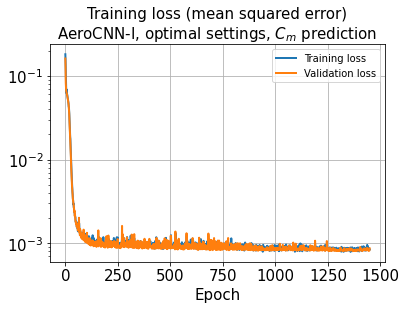

In [42]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

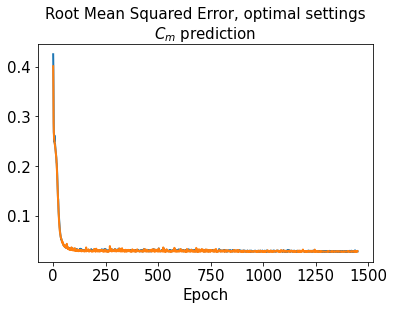

In [43]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

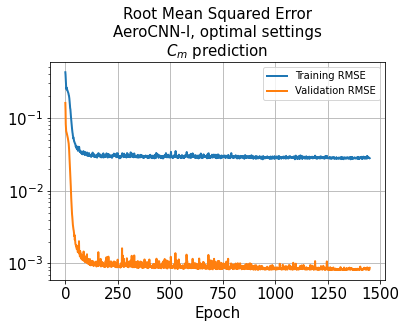

In [44]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [45]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 4ms/step - loss: 8.4376e-04 - rmse: 0.0279


In [46]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 5ms/step - loss: 8.1870e-04 - rmse: 0.0275


In [47]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 8ms/step - loss: 9.3925e-04 - rmse: 0.0296


In [48]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 3ms/step


In [49]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [50]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [51]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [52]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [53]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [54]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.06381952396116719
2.4328373532345804


In [55]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.06402547207198651
2.437510151048138


In [56]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.06794448001721315
2.629698242765531


In [57]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [58]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [59]:
model_directory = "D:\\TrainedModels\\20230103"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly15Coords)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [60]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [61]:
os.chdir(storage_dir)

In [62]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [63]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [64]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [65]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [66]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [67]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [68]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

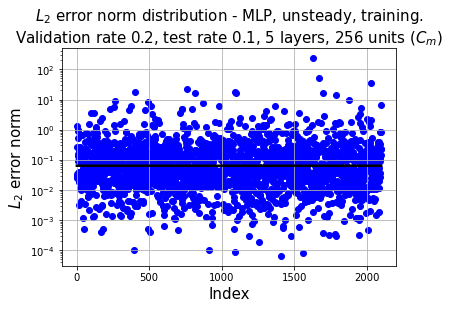

In [69]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

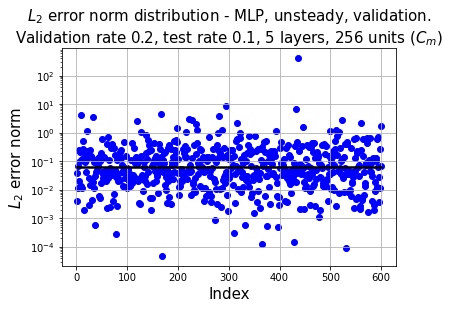

In [70]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

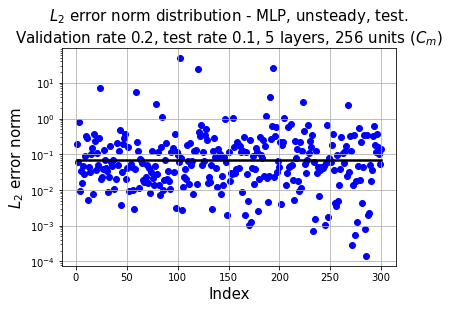

In [71]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [72]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 3ms/step


In [73]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [74]:
max(predicted)

array([0.9630153], dtype=float32)

In [75]:
print(l2_error(predicted, y))

0.06428333992241746


In [76]:
cm[2000]

array([0.00682824])

In [77]:
cm[1000]

array([0.0014248])

In [78]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [79]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [80]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [81]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [82]:
len(predicted[index_train])

2100

In [83]:
len(predicted[index_val])

601

In [84]:
len(predicted[index_test])

301

In [85]:
x_time += 10

L2 error of Cm: 0.0738


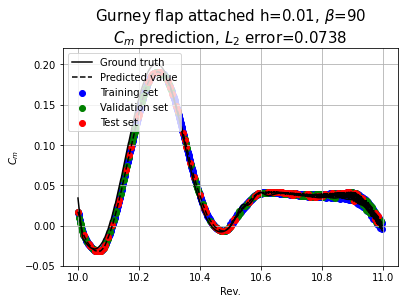

L2 error of Cm: 0.0151


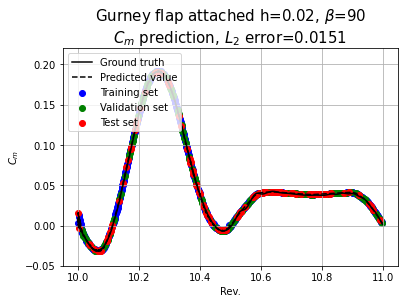

L2 error of Cm: 0.0823


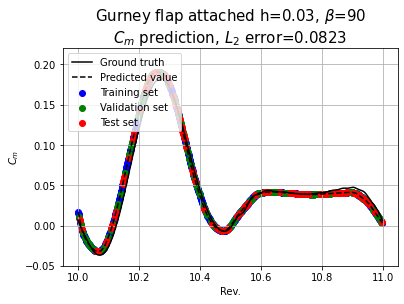

In [86]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [87]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    plt.xlim([10.17, 10.23])
    plt.ylim([0.11, 0.15])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0738


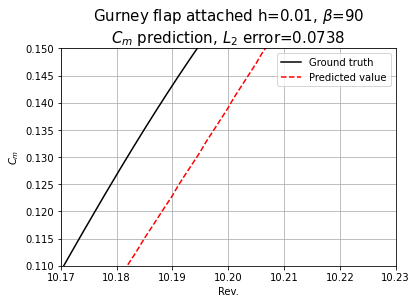

L2 error of Cm: 0.0151


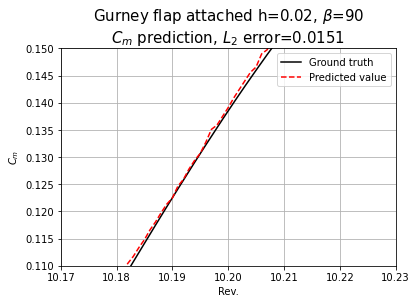

L2 error of Cm: 0.0823


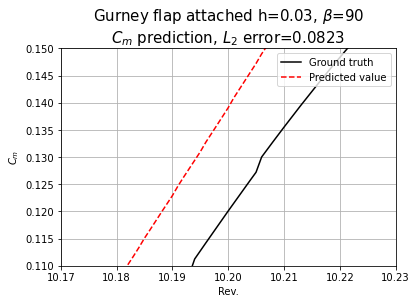

In [88]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0738


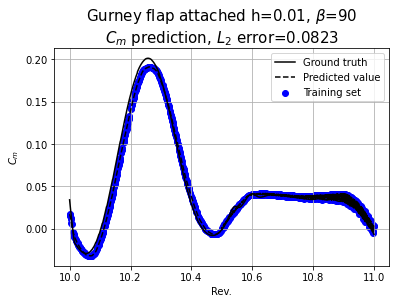

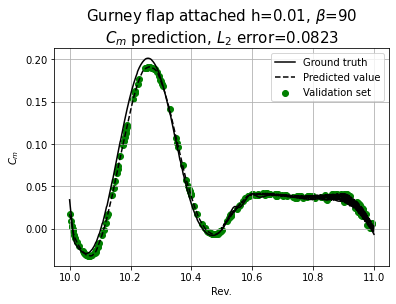

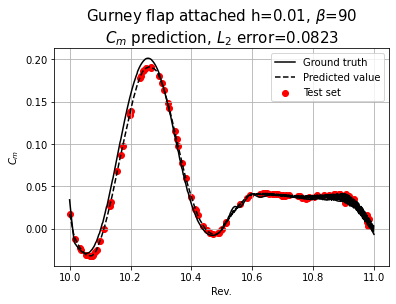

L2 error of Cm: 0.0151


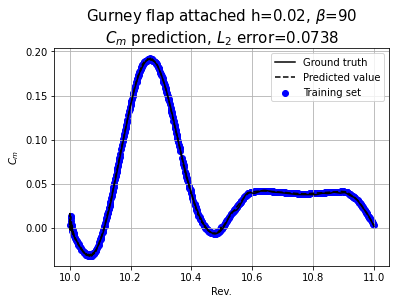

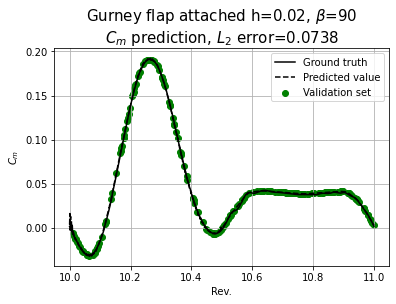

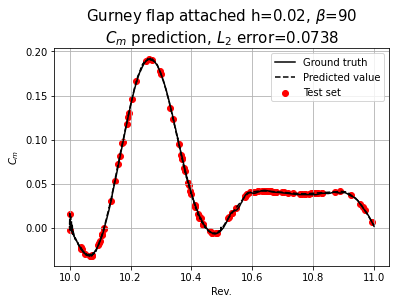

L2 error of Cm: 0.0823


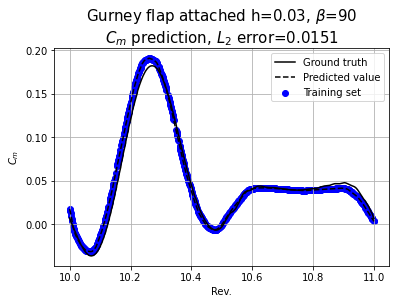

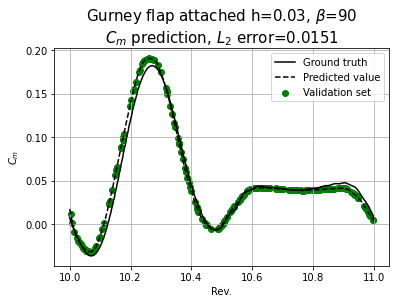

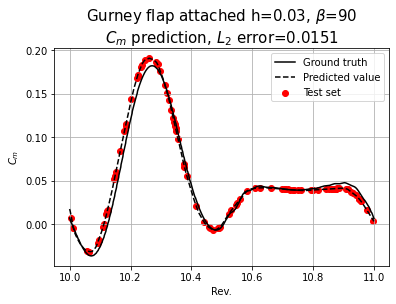

In [89]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()